In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

Train shape: (35744, 8)
Test shape:  (41702, 8)
Validation shape:  (41702, 8)

Train label distribution:
label
1    20373
0    15371
Name: count, dtype: int64

Validation label distribution:
label
1    23769
0    17933
Name: count, dtype: int64

Test label distribution:
label
1    23770
0    17932
Name: count, dtype: int64
Xtr columns: ['text', 'word_count', 'sentence_count', 'words_per_sentence', 'domain']
Xtr shape: (35744, 5)

================ Logistic Regression ================
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__C': 10, 'preprocess__text__max_features': 100000, 'preprocess__text__ngram_range': (1, 2)}
Best CV F1: 0.9863760086537136
Tuned Test F1: 0.9884974989974885
Tuned Test report:
              precision    recall  f1-score   support

           0      0.981     0.989     0.985     17932
           1      0.992     0.985     0.988     23770

    accuracy                          0.987     41702
   macro avg      0.986     0.987     

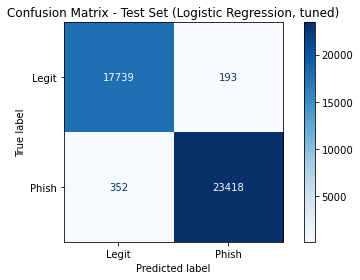


================ Linear SVM ================
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Daria\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Daria\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'clf__C': 1, 'preprocess__text__max_features': 100000, 'preprocess__text__ngram_range': (1, 2)}
Best CV F1: 0.9875195482791733
Tuned Test F1: 0.989282700421941
Tuned Test report:
              precision    recall  f1-score   support

           0      0.982     0.990     0.986     17932
           1      0.992     0.986     0.989     23770

    accuracy                          0.988     41702
   macro avg      0.987     0.988     0.988     41702
weighted avg      0.988     0.988     0.988     41702



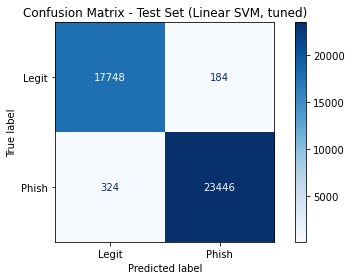


================ Random Forest ================
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best CV F1: 0.9810011403447062
Tuned Test F1: 0.9853804244935737
Tuned Test report:
              precision    recall  f1-score   support

           0      0.981     0.981     0.981     17932
           1      0.985     0.985     0.985     23770

    accuracy                          0.983     41702
   macro avg      0.983     0.983     0.983     41702
weighted avg      0.983     0.983     0.983     41702



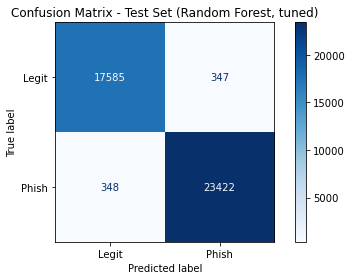


================ Naive Bayes ================
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__alpha': 0.1, 'preprocess__text__max_features': 100000, 'preprocess__text__ngram_range': (1, 2)}
Best CV F1: 0.9806581230197221
Tuned Test F1: 0.9816723699955914
Tuned Test report:
              precision    recall  f1-score   support

           0      0.978     0.973     0.976     17932
           1      0.980     0.984     0.982     23770

    accuracy                          0.979     41702
   macro avg      0.979     0.978     0.979     41702
weighted avg      0.979     0.979     0.979     41702



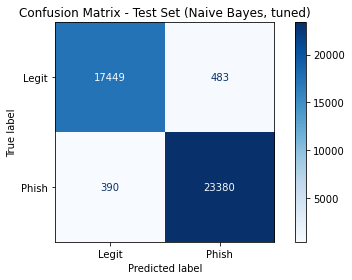

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")
val_df=pd.read_csv("data/val.csv")

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)
print("Validation shape: ",val_df.shape)

print("\nTrain label distribution:")
print(train_df["label"].value_counts())

print("\nValidation label distribution:")
print(val_df["label"].value_counts())

print("\nTest label distribution:")
print(test_df["label"].value_counts())

# 2) Define X / y for training,testing and validation
feature_cols = ["text", "word_count", "sentence_count", "words_per_sentence", "domain"]
Xtr = train_df[feature_cols].copy()
ytr = train_df["label"].astype(int)

Xte = test_df[feature_cols].copy()
yte = test_df["label"].astype(int)

Xva=val_df[feature_cols].copy()
yva=val_df["label"].astype(int)

print("Xtr columns:", Xtr.columns.tolist())
print("Xtr shape:", Xtr.shape)

# === Columns ===
text_col = "text"
num_cols = ["word_count", "sentence_count", "words_per_sentence"]
cat_cols = ["domain"]

# === Preprocessing ===
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1, 2),
            min_df=2,
            max_features=100_000
        ), text_col),
        ("num", StandardScaler(with_mean=False), num_cols),
        ("domain", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# === Base models ===
models = {
    "Logistic Regression": LogisticRegression(
        C=10.0,
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "Linear SVM": LinearSVC(
        C=1.0,
        class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ),
    "Naive Bayes": MultinomialNB()
}

# === Hyperparameter grids (names use: preprocess__text__..., clf__...) ===
param_grids = {
    "Logistic Regression": {
        "preprocess__text__ngram_range": [(1, 1), (1, 2)],
        "preprocess__text__max_features": [50_000, 100_000],
        "clf__C": [0.1, 1, 10]
    },
    "Linear SVM": {
        "preprocess__text__ngram_range": [(1, 1), (1, 2)],
        "preprocess__text__max_features": [50_000, 100_000],
        "clf__C": [0.1, 1, 10]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [None, 20, 40],
        "clf__min_samples_split": [2, 5]
    },
    "Naive Bayes": {
        "preprocess__text__ngram_range": [(1, 1), (1, 2)],
        "preprocess__text__max_features": [50_000, 100_000],
        "clf__alpha": [0.1, 1.0]
    }
}

for name, clf in models.items():
    print(f"\n================ {name} ================")

    # Base pipeline
    base_pipe = Pipeline([
        ("preprocess", preprocess),
        ("clf", clf)
    ])

    # --- Grid search for this model ---
    grid = param_grids[name]
    gs = GridSearchCV(
        base_pipe,
        grid,
        scoring="f1",
        n_jobs=-1,
        cv=3,
        verbose=1
    )
    gs.fit(Xtr, ytr)

    print("Best params:", gs.best_params_)
    print("Best CV F1:", gs.best_score_)

    # Use best model
    best_pipe = gs.best_estimator_


    # Test with tuned model
    test_pred = best_pipe.predict(Xte)
    print("Tuned Test F1:", f1_score(yte, test_pred))
    print("Tuned Test report:")
    print(classification_report(yte, test_pred, digits=3))

    # Confusion matrix (test)
    cm = confusion_matrix(yte, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Legit", "Phish"])
    disp.plot(values_format="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Test Set ({name}, tuned)")
    plt.tight_layout()
    plt.show()

In [ ]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),      # unigrams + bigrams
        min_df=2,
        max_features=100_000,
        stop_words="english"
    )),
    ("lr", LogisticRegression(
        max_iter=1000,
        C=1.0,
        class_weight="balanced"
    ))
])

In [ ]:
# for name, df in [("Train", train), ("Val", val), ("Test", test)]:
#     print(f"\n{name} length by label:")
#     print(df.assign(length=df["text"].str.len())
#             .groupby("label")["length"]
#             .describe())

# vectorizer = pipe.named_steps["tfidf"]
# feature_names = vectorizer.get_feature_names_out()
# print(feature_names[:50])

#print(np.percentile(test_prob, [1,5,50,95,99]))

In [ ]:

pipe.fit(Xtr, ytr)

# Validation
val_pred = pipe.predict(Xva)
print("Validation F1:", f1_score(yva, val_pred))
print(classification_report(yva, val_pred, digits=3))


In [ ]:
grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [50_000, 100_000],
    "lr__C": [0.1, 1, 10]
}
gs = GridSearchCV(pipe, grid, scoring="f1", n_jobs=-1, cv=3, verbose=1)
gs.fit(Xtr, ytr)
print("Best:", gs.best_params_, gs.best_score_)
pipe = gs.best_estimator_

In [ ]:
pred_test = pipe.predict(Xte)
print("Test F1:", f1_score(yte, pred_test))
print(classification_report(yte, pred_test, digits=3))

In [ ]:
#ensures we have probabilities and predictions for the test set
if "test_prob" not in globals():
    #LogisticRegression supports both predict_proba and decision_function
    test_prob = pipe.predict_proba(Xte)[:, 1]

if "pred_test" not in globals():
    pred_test = (test_prob >= 0.5).astype(int)  # or keep your tuned threshold if you used one

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(yte, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Phish"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

In [ ]:
prec, rec, _ = precision_recall_curve(yte, test_prob)
ap = average_precision_score(yte, test_prob)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#grabs feature names from the fitted TfidfVectorizer inside the pipeline
tfidf = pipe.named_steps["tfidf"]
lr    = pipe.named_steps["lr"]

feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_[0]

def plot_top_terms(coefs, feature_names, top_n=20, title=""):
    idx = np.argsort(coefs)[-top_n:]
    terms = feature_names[idx]
    vals  = coefs[idx]

    plt.figure(figsize=(8, 6))
    y = np.arange(top_n)
    plt.barh(y, vals)
    plt.yticks(y, terms)
    plt.xlabel("Coefficient")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_bottom_terms(coefs, feature_names, top_n=20, title=""):
    idx = np.argsort(coefs)[:top_n]
    terms = feature_names[idx]
    vals  = coefs[idx]

    plt.figure(figsize=(8, 6))
    y = np.arange(top_n)
    plt.barh(y, vals)
    plt.yticks(y, terms)
    plt.xlabel("Coefficient")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_terms(coefs, feature_names, top_n=20, title="Top Terms Indicative of Phishing (positive coefficients)")
plot_bottom_terms(coefs, feature_names, top_n=20, title="Top Terms Indicative of Legitimate (negative coefficients)")

In [ ]:
summary = pd.DataFrame({
    "Split": ["Test"],
    "Accuracy": [accuracy_score(yte, pred_test)],
    "Precision": [precision_score(yte, pred_test)],
    "Recall": [recall_score(yte, pred_test)],
    "F1": [f1_score(yte, pred_test)],
    "PR-AUC": [average_precision_score(yte, test_prob)]
})

summary.round(3)

In [ ]:
ths = np.linspace(0.05, 0.95, 37)
f1s = [f1_score(yte, (test_prob >= t).astype(int)) for t in ths]

plt.figure()
plt.plot(ths, f1s, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Test)")
best_i = int(np.argmax(f1s))
plt.scatter([ths[best_i]], [f1s[best_i]])
plt.title(f"F1 vs Threshold (best t={ths[best_i]:.2f}, F1={f1s[best_i]:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import joblib, json
from pathlib import Path

Path("models").mkdir(exist_ok=True)
joblib.dump(pipe, "models/tfidf_logreg.joblib")

#if we later decided on a tuned threshold, will set it here; otherwise keep 0.5 because F1 is extremely good now
chosen_threshold = 0.5
(Path("models") / "threshold.txt").write_text(str(chosen_threshold))

#saves a small metrics json
metrics = {
    "test": {
        "accuracy": float(accuracy_score(yte, pred_test)),
        "precision": float(precision_score(yte, pred_test)),
        "recall": float(recall_score(yte, pred_test)),
        "f1": float(f1_score(yte, pred_test)),
        "pr_auc": float(average_precision_score(yte, test_prob)),
    }
}
Path("results").mkdir(exist_ok=True)
(Path("results") / "baseline_metrics.json").write_text(json.dumps(metrics, indent=2))

print("Saved: models/tfidf_logreg.joblib, models/threshold.txt, results/baseline_metrics.json")